https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

# Jak przewidzieć wiele szeregów czasowych jednocześnie za pomocą Scikit-Learn (z przykładem prognozowania sprzedaży)

Masz wiele punktów danych szeregów czasowych i chcesz przewidzieć następny krok (lub kroki). Co powinieneś teraz zrobić? Wytrenuj model dla każdej serii? Czy jest sposób na dopasowanie modelu do wszystkich serii razem? Co jest lepsze?

Widziałem wielu analityków danych, którzy zastanawiali się nad podejściem do tego problemu, tworząc jeden model dla każdego produktu. Chociaż jest to jedno z możliwych rozwiązań, prawdopodobnie nie będzie najlepsze.

W tym miejscu pokażę, jak wytrenować pojedynczy model do prognozowania wielu szeregów czasowych w tym samym czasie. Ta technika zwykle tworzy potężne modele, które pomagają zespołom wygrywać konkursy na uczenie maszynowe i można je wykorzystać w projekcie.

I nie potrzebujesz do tego modeli głębokiego uczenia!

# Indywidualne modele uczenia maszynowego a duży model dla wszystkiego

W uczeniu maszynowym więcej danych zwykle oznacza lepsze prognozy. Jeśli spróbujesz stworzyć jeden model dla każdej serii, będziesz miał pewne problemy z seriami, które zawierają niewiele danych lub nie zawierają ich wcale.

Gdy łączysz wszystkie serie w jeden zestaw danych, aby wytrenować jeden model, używasz znacznie więcej danych. Może to pomóc modelowi lepiej działać!

Biorąc pod uwagę więcej niż jedną serię na raz, algorytmy uczenia maszynowego będą w stanie nauczyć się bardziej subtelnych wzorców, które powtarzają się w różnych seriach. Produkt staje się zmienną w naszym modelu.

Najpierw zaimportujmy nasze podstawowe narzędzia:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor



df = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
#print(is.data.frame(df))
#print(ncol(df))
#print(nrow(df))
#print(names(df))
df

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,P815,0,0,1,0,0,2,1,0,0,...,0.00,0.33,0.33,0.00,0.00,0.33,0.00,0.00,0.67,0.00
807,P816,0,1,0,0,1,2,2,6,0,...,0.43,0.43,0.57,0.29,0.57,0.71,0.71,0.71,0.86,0.71
808,P817,1,0,0,0,1,1,2,1,1,...,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.75
809,P818,0,0,0,1,0,0,0,0,1,...,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.00


# Przygotowanie danych
Dane zostały pozyskane z Repozytorium UCI.

Tutaj postaramy się prognozować sprzedaż dla 811 produktów. Nasz zbiór danych zawiera rekordy sprzedaży z 52 tygodni dla każdego z produktów.

Oznacza to, że pierwotnie mamy 811 szeregów czasowych z 52 punktami danych każdy. Tutaj biorę tylko kod produktu i nieznormalizowaną tygodniową sprzedaż dla każdego produktu.

Tak wyglądają dane:

In [2]:
data = pd.read_csv("/media/wojciech/D6DE33C1DE339927/1A/Sales_Transactions_Dataset_Weekly.csv")
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


W tym momencie wielu analityków danych próbowałoby dopasować model do każdego produktu. I chociaż może to działać dobrze, możemy mieć problemy z powodu posiadania tylko 52 punktów danych dla każdego modelu, co jest naprawdę niskie!

Ponieważ modele uczenia maszynowego mają tendencję do ulepszania się przy większej ilości danych, dlaczego nie spróbować połączyć wszystkich serii i wytrenować jednego modelu z większą ilością danych?

Aby to zrobić, musimy „stopić” dane. Oznacza to po prostu przekształcenie danych w taki sposób, w jaki każda linia staje się: kodem produktu, tygodniem, sprzedażą

Aby ułatwić nam życie, postanowiłem usunąć litery z kodu produktu i tygodnia.

In [3]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')
melt

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


In [4]:
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
melt['Product_Code']

0          1
1          2
2          3
3          4
4          5
        ... 
42167    815
42168    816
42169    817
42170    818
42171    819
Name: Product_Code, Length: 42172, dtype: int64

In [5]:
melt

,Product_Code,Week,Sales
0,1,W0,11
1,2,W0,7
2,3,W0,7
3,4,W0,12
4,5,W0,8
...,...,...,...
42167,815,W51,0
42168,816,W51,5
42169,817,W51,3
42170,818,W51,0


In [6]:
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)
melt

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0


In [7]:
melt = melt.sort_values(['Week', 'Product_Code'])
melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [8]:
melt.shape

(42172, 3)

Teraz mamy 42172 wiersze do trenowania naszego modelu.

# Podstawowa inżynieria funkcji

Potrzebujemy zmiennych do wysłania do naszego modelu i uzyskania prognoz. 
Na razie, oprócz kodu produktu i tygodnia, stworzę dwie funkcje, które zwykle bardzo pomagają w prognozowaniu szeregów czasowych: opóźnienia i różnice.

Sprzedaż w zeszłym tygodniu: jest to po prostu kwota sprzedaży, jaką produkt miał w poprzednim tygodniu
Różnica z ostatniego tygodnia: różnica między wielkością sprzedaży w poprzednim tygodniu i tygodniu poprzedzającym (t-1 - t-2)

In [9]:
melt2 = melt.copy() ## skopiował df

In [10]:
melt2['Last_Week_Sales'] = melt2.groupby(['Product_Code'])['Sales'].shift() ## zrobił przesunięcie o jeden
#df[df.iso_country.isin(['CZ','SK','PL'])&(df.type =='large_airport')]

melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)][['Product_Code','Sales','Last_Week_Sales']] 
#melt2[['Sales','Last_Week_Sales']]

,Product_Code,Sales,Last_Week_Sales
5678,2,3,6.0
6489,2,3,3.0
7300,2,3,3.0
8111,2,2,3.0
8922,2,2,2.0
9733,2,6,2.0
10544,2,2,6.0


In [11]:
melt2['Last_Week_Diff'] = melt2.groupby(['Product_Code'])['Last_Week_Sales'].diff() # różnica między kolejnymi dniami np. 6-2 = 4

In [12]:
melt2[melt2.Week.isin([7,8,9,10,11,12,13])&(melt2.Product_Code ==2)]

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
5678,2,7,3,6.0,5.0
6489,2,8,3,3.0,-3.0
7300,2,9,3,3.0,0.0
8111,2,10,2,3.0,0.0
8922,2,11,2,2.0,-1.0
9733,2,12,6,2.0,0.0
10544,2,13,2,6.0,4.0


In [13]:
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
0,1,0,11,NaN,NaN
1,2,0,7,NaN,NaN
2,3,0,7,NaN,NaN
3,4,0,12,NaN,NaN
4,5,0,8,NaN,NaN


In [14]:
melt2 = melt2.dropna()  # wykasowane wszystkie wiersze zawierające NaN
melt2.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


# Ocena wyniku

Aby wiedzieć, czy nasz model jest dobry, potrzebujemy metryki oceny. Miarą, którą bardzo lubię w prognozowaniu sprzedaży, jest błąd logarytmu średniokwadratowego.

To jest nasz dobrze znany RMSE zastosowany do dziennika celu i wyniku prognozy.

Działa jako przybliżenie błędu procentowego między naszym modelem prognozowania a wartością docelową, co jest dobrym sposobem na zrozumienie błędów popełnianych przez nasz model.

In [15]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Ustawianie linii bazowej i podziału walidacji

Załóżmy, że w prawdziwym życiu Twój model będzie działał w każdą niedzielę wieczorem, aby już w poniedziałek menedżerowie mogli podejmować decyzje na podstawie przewidywań na następny tydzień.

Aby sprawdzić, czy nasz model będzie działał w tym scenariuszu, tygodni, których wcześniej nie widział, użyję walidacji z przesuwnym oknem.

### Oznacza to, że będziemy symulować trenowanie modelu we wszystkich tygodniach aż do tego, który chcemy prognozować i oceniać nasz wynik w nowym tygodniu.

Aby uniknąć posiadania bardzo dobrego modelu w ciągu niewielkiej liczby tygodni, po prostu ze względu na szczęście, będę używał tygodni od 40 do 52, powtarzając proces dla jednego na raz (za kazdym razem) i obliczając wynik.

Ponieważ jest to tylko demonstracja metody, dla uproszczenia nie oddzielam zestawu testowego. W swoich projektach zawsze trzymaj pewne okresy poza walidacją, aby ocenić swój model po zakończeniu jego opracowywania.

Jest to bardzo ważne i zapewnia większe bezpieczeństwo podczas wdrażania modelu.

Aby upewnić się, że model jest wart zastosowania, lubię ustalać punktację bazową, którą musi pokonać. W tym przypadku dość silna linia bazowa wykorzystuje sprzedaż z ostatniego tygodnia jako prognozę sprzedaży w tym tygodniu.

In [16]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week] ## wszystkie weekendy porzed 4 weekendem
    val = melt2[melt2['Week'] == week]  ## wszystkie weekendy mniejsze do 5 i równe 4
train

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0
...,...,...,...,...,...
3239,815,3,0,1.0,1.0
3240,816,3,0,0.0,-1.0
3241,817,3,0,0.0,0.0
3242,818,3,1,0.0,0.0


In [17]:
val  # wszystkie weekendy mniejsze do 5 i równe 4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
3244,1,4,13,8.0,-2.0
3245,2,4,7,2.0,-1.0
3246,3,4,10,9.0,1.0
3247,4,4,9,5.0,-8.0
3248,5,4,6,11.0,-2.0
...,...,...,...,...,...
4050,815,4,0,0.0,-1.0
4051,816,4,1,0.0,0.0
4052,817,4,1,0.0,0.0
4053,818,4,0,1.0,1.0


In [18]:
for week in range(4,5):
    train = melt2[melt2['Week'] < week]  ## wszystkie weekendy porzed 40 weekendem
    val = melt2[melt2['Week'] == week]   ## wszystkie weekendy od 40 do 51 weekend

    p = val['Last_Week_Sales'].values     ## to poprostu wylistowanie wektora 'Last_Week_Sales'
p

array([ 8.,  2.,  9.,  5., 11.,  7.,  7.,  9.,  7., 29., 14.,  6.,  6.,
       11., 42., 43., 28., 38., 36., 10.,  8.,  9.,  3., 33., 32.,  8.,
       39., 41., 17., 34.,  7.,  4., 17., 55., 27., 45., 42., 52., 39.,
       51., 43., 27., 43., 36., 34., 38., 28., 33., 38.,  8., 27., 48.,
        8., 40., 42., 36., 43., 41., 11., 27., 47., 22., 44., 42., 10.,
       34., 44.,  9., 39., 31.,  8., 41., 46., 15., 27., 45.,  2., 39.,
       41., 40.,  5., 13., 38., 39., 38., 32., 39., 30., 31., 39., 13.,
       40., 13.,  9., 13., 44., 40.,  4., 21.,  9., 47., 32.,  7.,  5.,
        2., 16., 24.,  0.,  5.,  6.,  4., 51., 37.,  8., 13.,  8.,  3.,
       10., 33., 30., 10.,  8.,  6.,  7., 10.,  3.,  2., 39., 47., 41.,
       35., 41., 38., 35., 37., 52., 41., 35., 38., 46., 34., 43., 42.,
       12.,  9., 13.,  9.,  3.,  6.,  4.,  8.,  8., 10.,  6.,  3.,  6.,
        7.,  2.,  5., 13.,  7.,  9.,  6.,  9., 16., 11., 41., 59., 43.,
       43.,  6., 40., 47., 43., 28., 26., 48., 36., 36., 43., 38

Teraz wiemy, że nasz model musi mieć lepszy błąd niż około 0,51. Byłoby to około 50% błędu w każdej prognozie, co wydaje się ogromne! Ale czy to naprawdę?

Jeśli przyjrzymy się rozkładowi sprzedaży w zbiorze danych, zobaczymy, że wiele przedmiotów sprzedaje bardzo małe ilości. Powinniśmy więc oczekiwać, że błąd będzie wyglądał na „wysoki”.

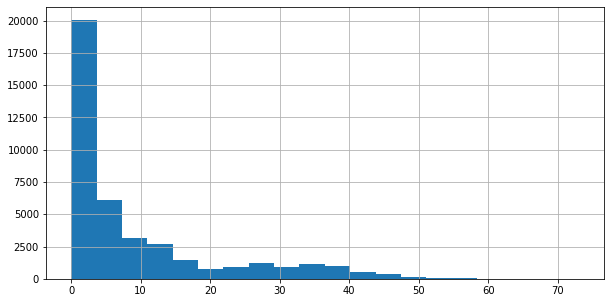

In [19]:
melt2['Sales'].hist(bins=20, figsize=(10,5))

# Tworzenie modelu

Teraz, gdy mamy linię bazową, spróbujmy ją pokonać!

Jako pierwszy model wytrenujmy Losowy Las. Poza tym, że jesteśmy silnym modelem z ustrukturyzowanymi danymi (takimi jak ten, które mamy), zwykle możemy już uzyskać bardzo dobry wynik, po prostu ustawiając dużą liczbę drzew.

Zwykle mówię analitykom danych, że Losowy Las to bardzo dobry model do wykorzystania w leniwy dzień. Ustawiasz tylko liczbę drzew na maksymalną, którą twój komputer może uruchomić i uzyskać dobry model (miejmy nadzieję).

Zostanę Tydzień jako funkcję, chociaż nasz model nigdy nie widział nowej wartości tygodnia. Może się zdarzyć, że np. po 35 tygodniu mamy większą sprzedaż produktu. Ten rodzaj efektu może zostać uchwycony przez model.

Ponieważ drzewa decyzyjne dobrze radzą sobie z cechami kategorialnymi nawet w kodowaniu porządkowym, zostawiłem je w tym formacie.

W każdym razie bądź ostrożny z tego typu funkcjami.



# SUPER!

Stosując Losowy Las do naszych początkowych zmiennych, uzyskaliśmy dobrą redukcję błędu (około 10%). To bardzo dobry sposób na rozpoczęcie.

Teraz spróbujmy dodać kilka funkcji sprzed kilku tygodni. Najpierw dodajmy opóźnienie i różnicę sprzedaży na tydzień przed poprzednim.

In [20]:
melt3 = melt.copy()
melt3['Last_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift()
melt3['Last_Week_Diff'] = melt3.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt3['Last-1_Week_Sales'] = melt3.groupby(['Product_Code'])['Sales'].shift(2)
melt3['Last-1_Week_Diff'] = melt3.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt3 = melt3.dropna()
melt3.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
2433,1,3,8,10.0,-2.0,12.0,1.0
2434,2,3,2,3.0,-3.0,6.0,-1.0
2435,3,3,9,8.0,-3.0,11.0,4.0
2436,4,3,5,13.0,5.0,8.0,-4.0
2437,5,3,11,13.0,8.0,5.0,-3.0


# WspaniaLE! Kolejna obniżka!

Czy możesz odgadnąć mój następny pomysł?

Wypróbujmy oczywiście model z jeszcze jednym opóźnieniem i różnicą!

In [21]:
melt4 = melt.copy()
melt4['Last_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Last_Week_Diff'] = melt4.groupby(['Product_Code'])['Last_Week_Sales'].diff()
melt4['Last-1_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Last-1_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
melt4['Last-2_Week_Sales'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Last-2_Week_Diff'] = melt4.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
melt4 = melt4.dropna()
melt4.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0


In [22]:
melt4

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
3244,1,4,13,8.0,-2.0,10.0,-2.0,12.0,1.0
3245,2,4,7,2.0,-1.0,3.0,-3.0,6.0,-1.0
3246,3,4,10,9.0,1.0,8.0,-3.0,11.0,4.0
3247,4,4,9,5.0,-8.0,13.0,5.0,8.0,-4.0
3248,5,4,6,11.0,-2.0,13.0,8.0,5.0,-3.0
...,...,...,...,...,...,...,...,...,...
42167,815,51,0,2.0,2.0,0.0,0.0,0.0,-1.0
42168,816,51,5,6.0,1.0,5.0,0.0,5.0,0.0
42169,817,51,3,4.0,4.0,0.0,0.0,0.0,0.0
42170,818,51,0,2.0,2.0,0.0,0.0,0.0,0.0


In [23]:
for week in range(36,42):
    train = melt4[melt4['Week'] < week]   ## okres treningowy do 36 tygodnia
    val = melt4[melt4['Week'] == week]    ## okres testowy od 36 tygodnia włącznie do 42 tygodnia 
                                        ## 43-52 tydzień to okres super testowy

    Xtrain, Xtest = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)  # podział na zmienne treningowe i testowe
    ytrain, ytest = train['Sales'].values, val['Sales'].values                  # podział na wyniki testowe i treningowe 

In [24]:
# kolorowe wydruki
class colors:
           
    def green(self,text):
           print('\033[32m', text, '\033[0m', sep='') 

    def blue(self,text):
         print('\033[34m', text, '\033[0m', sep='')

    def magenta(self,text):
         print('\033[35m', text, '\033[0m', sep='')  

    def cyan(self,text):
         print('\033[36m', text, '\033[0m', sep='')

    def red(self,text):
         print('\033[31m', text, '\033[0m', sep='')  

    def yellow(self,text):
         print('\033[33m', text, '\033[0m', sep='')  
pass

CO = colors()

<span style="font-size: 180%;color:#1155cc">Uruchamiam paczkę modeli regresji

<span style="font-size: 110%;color:#1155cc">Celem jest wybranie najlepszego modelu.

In [25]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import warnings   
warnings.filterwarnings("ignore")

modele = [KNeighborsRegressor(),
          DecisionTreeRegressor(),
          BaggingRegressor(),
          GradientBoostingRegressor(),
          LinearRegression(),
          AdaBoostRegressor(),
          Ridge(),
          HuberRegressor(),
          ElasticNetCV(),
          ExtraTreesRegressor(),
          RandomForestRegressor(),
          #SVR()
          ] 

nazwy = ['K-Neighbors Regressor',
          'Decision Tree Regressor',
          'Bagging Regressor',
          'Gradient Boosting Regressor',
          'Linear Regression',
          'AdaBoost Regressor',
          'Ridge',
          'Huber Regressor',
          'Elastic Net CV',
          'ExtraTreesRegressor',
          'Random Forest Regressor',
          #'Support Vector Regression'
          ]

In [26]:
def model_val(t):
    
    global mean_dev,r2
    
    kfold = model_selection.KFold(n_splits=12, random_state=148)
    mean_dev = model_selection.cross_val_score(t, Xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_error')
    mean_dev = np.round(mean_dev, decimals=1)
    r2 = model_selection.cross_val_score(t, Xtrain, ytrain, cv=kfold, scoring='r2')
    r2 = np.round(r2, decimals=2)
    
    return mean_dev,r2


K-Neighbors Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.91 0.92 0.91 0.9  0.91 0.84 0.79 0.88 0.89 0.9  0.89]
Mean_dev:  [-2.5 -2.4 -2.4 -2.4 -2.4 -2.4 -2.8 -2.8 -2.2 -2.1 -2.1 -2.2]


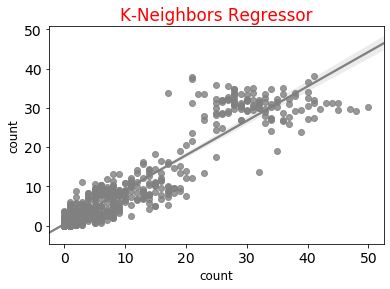

time: 2.0 seconds


Decision Tree Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.83 0.84 0.85 0.85 0.84 0.84 0.77 0.63 0.81 0.8  0.8  0.81]
Mean_dev:  [-3.3 -3.2 -3.2 -3.2 -3.1 -3.1 -3.4 -3.7 -2.8 -2.9 -2.9 -3. ]


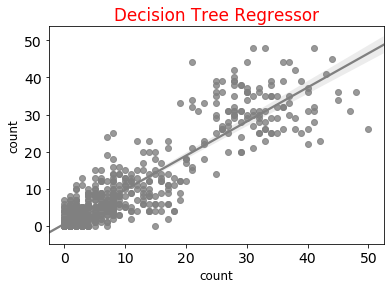

time: 3.0 seconds


Bagging Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.92 0.92 0.91 0.91 0.92 0.86 0.8  0.88 0.89 0.9  0.89]
Mean_dev:  [-2.5 -2.4 -2.4 -2.4 -2.4 -2.3 -2.5 -2.8 -2.2 -2.1 -2.2 -2.2]


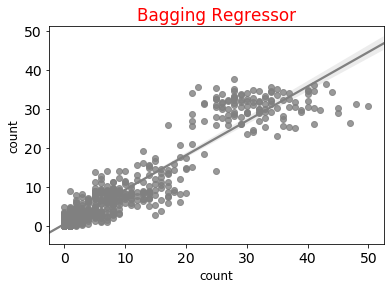

time: 18.0 seconds


Gradient Boosting Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.93 0.92 0.92 0.92 0.88 0.81 0.89 0.9  0.91 0.91]
Mean_dev:  [-2.4 -2.3 -2.3 -2.3 -2.4 -2.2 -2.5 -2.7 -2.1 -2.1 -2.1 -2.1]


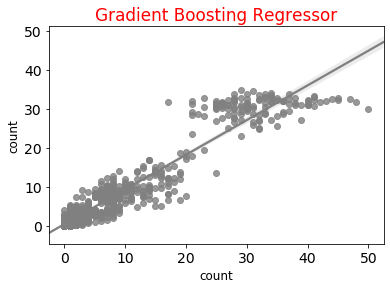

time: 49.0 seconds


Linear Regression
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.91 0.92 0.86 0.79 0.88 0.9  0.9  0.9 ]
Mean_dev:  [-2.4 -2.4 -2.3 -2.3 -2.4 -2.3 -2.6 -2.9 -2.2 -2.1 -2.1 -2.1]


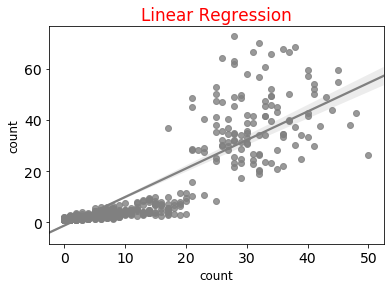

time: 1.0 seconds


AdaBoost Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.9  0.89 0.9  0.89 0.89 0.9  0.84 0.76 0.81 0.85 0.86 0.87]
Mean_dev:  [-3.7 -3.9 -3.9 -3.4 -3.4 -3.7 -3.6 -3.5 -3.5 -3.7 -3.6 -3.1]


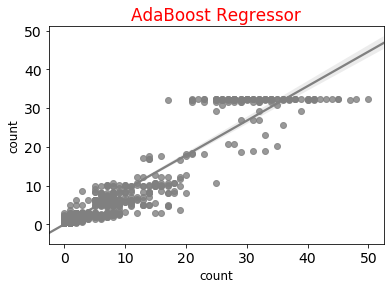

time: 28.0 seconds


Ridge
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.92 0.92 0.91 0.92 0.86 0.79 0.88 0.9  0.9  0.9 ]
Mean_dev:  [-2.4 -2.4 -2.3 -2.3 -2.4 -2.3 -2.6 -2.9 -2.2 -2.1 -2.1 -2.1]


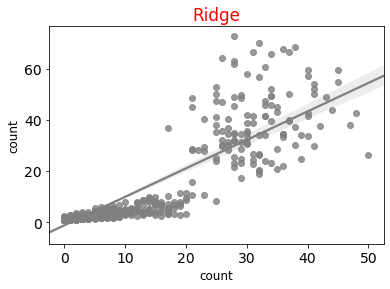

time: 0.0 seconds


Huber Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.92 0.92 0.92 0.91 0.92 0.87 0.79 0.88 0.89 0.9  0.9 ]
Mean_dev:  [-2.3 -2.4 -2.3 -2.3 -2.3 -2.2 -2.5 -2.8 -2.2 -2.1 -2.1 -2.1]


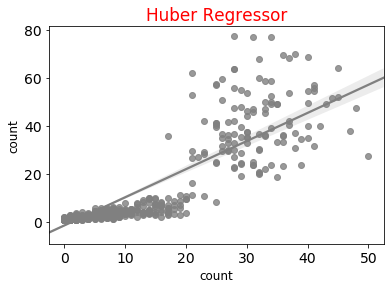

time: 9.0 seconds


Elastic Net CV
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.91 0.92 0.92 0.91 0.92 0.87 0.8  0.88 0.89 0.9  0.9 ]
Mean_dev:  [-2.4 -2.5 -2.4 -2.4 -2.4 -2.3 -2.6 -2.9 -2.2 -2.2 -2.2 -2.1]


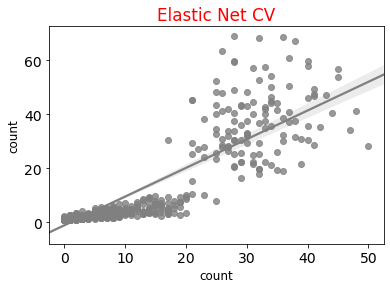

time: 8.0 seconds


ExtraTreesRegressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.91 0.92 0.92 0.92 0.91 0.92 0.88 0.8  0.89 0.9  0.9  0.9 ]
Mean_dev:  [-2.4 -2.4 -2.3 -2.3 -2.4 -2.3 -2.5 -2.8 -2.2 -2.1 -2.1 -2.2]


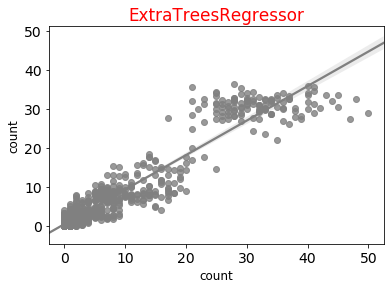

time: 105.0 seconds


Random Forest Regressor
-------------------------------cross_val, KFold = 12 ------
R2:  [0.92 0.92 0.93 0.92 0.91 0.92 0.87 0.81 0.89 0.9  0.9  0.91]
Mean_dev:  [-2.4 -2.4 -2.3 -2.3 -2.4 -2.3 -2.5 -2.7 -2.1 -2.1 -2.1 -2.1]


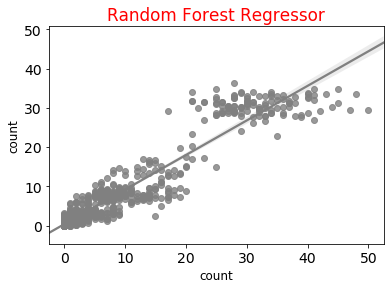

time: 173.0 seconds



In [27]:
for n,p in zip(nazwy,modele):      
    
    import matplotlib.pyplot as plt
    import time   
    
    start_time = time.time()
    
    results = model_val(p)
    print()
    CO.red(n)
    print("-------------------------------cross_val, KFold = 12 ------")
    print('R2: ', r2)
    print('Mean_dev: ', mean_dev)
    
    # wykres 
    plt.rc("font",size=14)
    clf = p
    clf.fit(Xtrain,np.log1p(ytrain))
    ypred = np.expm1(clf.predict(Xtest))

    ax = sns.regplot(ytest,ypred,color='grey')
    plt.title(n,color='r') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()
    
    # pomiar czasu
    n = (time.time() - start_time)
    n = np.round(n)
    CO.cyan('time: %s seconds' % n)    
    print()

 <span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja Linear Regression</span> <span style="font-size: 150%;color:white;background:RED"> 4 sekundy

Linear Regression: 0.8959346921404789
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(normalize=True)


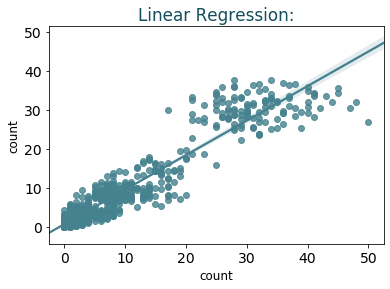

time: 1.0 seconds


In [28]:
#from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
import time   
    
start_time = time.time()


parameters = [{'fit_intercept': [True, False], 'normalize': [True, False],'copy_X': [True, False]}]



Linear_Regression = GridSearchCV(LinearRegression(), parameters)
Linear_Regression.fit(Xtrain,ytrain)


print('Linear Regression:',Linear_Regression.best_score_)
print(Linear_Regression.best_params_)
print(Linear_Regression.best_estimator_)

    # wykres
    
plt.rc("font",size=14)
Linear_Regression.fit(Xtrain,ytrain)
ypred = Linear_Regression.predict(Xtest)

ax = sns.regplot(ytest,ypred,color='#45818e')
plt.title('Linear Regression:',color='#134f5c') 
plt.ylabel('count', fontsize=12) 
plt.xlabel('count', fontsize=12) 
plt.show()


# pomiar czasu
n = (time.time() - start_time)
n = np.round(n)
print('time: %s seconds' % n)  

<span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja 'Random Forest Regressor'</span> <span style="font-size: 150%;color:white;background:RED"> 249 sekund 

 <span style="font-size: 150%;color:white;background:#1155cc">  GradientBoostingRegressor</span> <span style="font-size: 150%;color:white;background:RED"> 239 sekund

<span style="font-size: 150%;color:white;background:#1155cc"> Optymalizacja 'Extra Trees Regressor'</span> <span style="font-size: 150%;color:white;background:RED"> 4 sekundy 

 <span style="font-size: 150%;color:white;background:#674ea7"> SPRAWDZENIE JAK PROGNOZUJE WYBRANY MODEL NA STANDARDOWYCH DANYCH - CZY NIE JEST PRZEUCZONY
    
<span style="font-size: 110%;color:#1155cc">uruchamiamy teraz tą część Która miała służyć do sprawdzenia modelu: miesiąc 12

In [29]:
# K_Neighbors_Regressor, DecisionTreeRegressor, Bagging_Regressor, Gradient_Boosting_Regressor, Linear_Regression.predict(Xtest)
# Ada_Boost_Regressor, 


model = Linear_Regression    # WPISUJEMY MODEL PO OPTYMALIZACJI

In [30]:
def ModVal(model):

    from sklearn.model_selection import cross_val_score 

    ypred_tr = model.predict(Xtrain)

    r2_train = cross_val_score(model,Xtrain,ytrain, cv=12)
    r2_train = np.round(r2_train, decimals=2)
    print('r2 train:', r2_train)

    ax = sns.regplot(ytrain,ypred_tr,color='#741b47')
    plt.title('Model_train',color='#741b47') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()


    r2_test = cross_val_score(model,Xtest,ytest, cv=12)
    r2_test = np.round(r2_test, decimals=2)
    print('r2 testowy:', r2_test)

    ypred_te = model.predict(Xtest)

    ax = sns.regplot(ytest,ypred_te,color='#1155cc')
    plt.title('Model_test',color='#1155cc') 
    plt.ylabel('count', fontsize=12) 
    plt.xlabel('count', fontsize=12) 
    plt.show()


r2 train: [0.91 0.92 0.92 0.92 0.91 0.92 0.86 0.79 0.88 0.9  0.9  0.9 ]


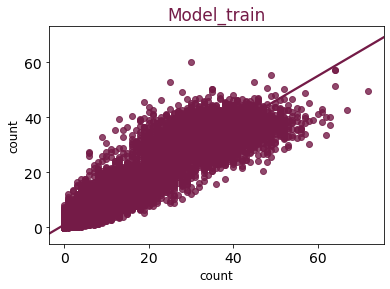

r2 testowy: [0.84 0.85 0.84 0.93 0.68 0.83 0.7  0.56 0.83 0.88 0.34 0.74]


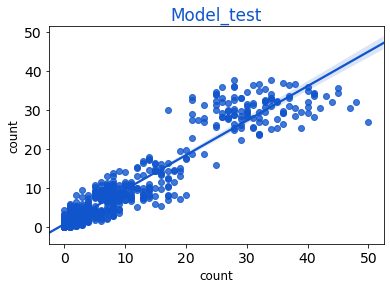

In [31]:
ModVal(Linear_Regression)

<span style="font-size: 160%;background: white;font-weight:bold;color:#1155cc">Zapisujemy wybrany model

In [32]:
import joblib

#RFC = RandomForestClassifier()
#RFC.fit(X_train, y_train) 

filename ='/home/wojciech/Pulpit/6/model_AA.pkl' 

# zapisanie
_ = joblib.dump(model, filename, compress=9)

<span style="font-size: 160%;background: white;font-weight:bold;color:#1155cc">Otwieramy z dysku wybrany model 

In [33]:
# otwarcie z dysku
model_AA = joblib.load(filename) 
model_AA

GridSearchCV(estimator=LinearRegression(),
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False],
                          'normalize': [True, False]}])

<span style="font-size: 160%;background: white;font-weight:bold;color:#1155cc">Użycie modelu
    
<span style="font-size: 110%;background: white;font-weight:normal;color:#1155cc"> Moge tu otworzyć każde dane i podstawić do modelu pod warunkiem że będą to dane mające strukturę pasującą do modelu - te same kolumny itp.
    
<span style="font-size: 210%;background: white;font-weight:normal;color:#1155cc"> Wybieram sobie notowania z okresu 43-52 tydzień to okres super testowy

In [34]:
SuperTest = melt4[melt4.Week.isin([43,44,45,46,47,48,49])] 
SuperTest.head(4)

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
34873,1,43,7,4.0,-7.0,11.0,4.0,7.0,-10.0
34874,2,43,4,2.0,-3.0,5.0,3.0,2.0,-1.0
34875,3,43,14,6.0,1.0,5.0,2.0,3.0,-6.0
34876,4,43,10,9.0,3.0,6.0,-6.0,12.0,4.0


In [35]:
from sklearn.model_selection import train_test_split 

y = SuperTest['Sales']
X = SuperTest.drop('Sales', axis=1)

#Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.25, random_state = 148)

In [36]:
model = model_AA

model

GridSearchCV(estimator=LinearRegression(),
             param_grid=[{'copy_X': [True, False],
                          'fit_intercept': [True, False],
                          'normalize': [True, False]}])

r2 train: [0.91 0.89 0.88 0.92 0.87 0.91 0.91 0.91 0.9  0.86 0.91 0.87]


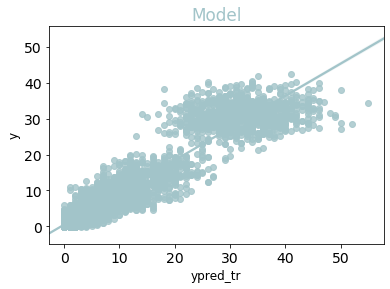

In [37]:
from sklearn.model_selection import cross_val_score 

ypred_tr = model_AA.predict(X)

r2_train = cross_val_score(model_AA,X,y, cv=12)
r2_train = np.round(r2_train, decimals=2)
print('r2 train:', r2_train)

ax = sns.regplot(y,ypred_tr,color='#a2c4c9')
plt.title('Model',color='#a2c4c9') 
plt.ylabel('y', fontsize=12) 
plt.xlabel('ypred_tr', fontsize=12) 
plt.show()

